# CSE4224 Project 2
#### Grant Butler | gbutler2020@my.fit.edu

#### Data Retrieval/Cleaning:
Here, I will use the Spotify API to get the audio features of the tracks in my library, and create a cleaned pandas dataframe to be used with PCA and t-SNE after.

In [2]:
#  ▄█    ▄▄▄▄███▄▄▄▄      ▄███████▄  ▄██████▄     ▄████████     ███        ▄████████
# ███  ▄██▀▀▀███▀▀▀██▄   ███    ███ ███    ███   ███    ███ ▀█████████▄   ███    ███
# ███▌ ███   ███   ███   ███    ███ ███    ███   ███    ███    ▀███▀▀██   ███    █▀
# ███▌ ███   ███   ███   ███    ███ ███    ███  ▄███▄▄▄▄██▀     ███   ▀   ███
# ███▌ ███   ███   ███ ▀█████████▀  ███    ███ ▀▀███▀▀▀▀▀       ███     ▀███████████
# ███  ███   ███   ███   ███        ███    ███ ▀███████████     ███              ███
# ███  ███   ███   ███   ███        ███    ███   ███    ███     ███        ▄█    ███
# █▀    ▀█   ███   █▀   ▄████▀       ▀██████▀    ███    ███    ▄████▀    ▄████████▀
#                                                ███    ███

from dotenv import dotenv_values
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.oauth2 import SpotifyOAuth
from spotipy.client import SpotifyException
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import json
import plotly.graph_objs as go

In [7]:

# use dotenv to import api creds
secrets = dotenv_values(".env")

# making authentication manager for spotipy to communicate with spotify
auth_manager = SpotifyClientCredentials(client_id=secrets["SPOTIPY_CLIENT_ID"],
                                        client_secret=secrets["SPOTIPY_CLIENT_SECRET"])

# auth_manager = SpotifyOAuth(client_id=secrets['SPOTIPY_CLIENT_ID'],
#                                                  client_secret=secrets['SPOTIPY_CLIENT_SECRET'],
#                                                  redirect_uri='http://127.0.0.1',
#                                                  scope='user-library-read')

sp = spotipy.Spotify(auth_manager=auth_manager)  # making spotipy object
sp.trace = False  # no debugging needed

# getting track ids from playlist

# grabbing the track ids and adding them to an array passed into them


def show_tracks(results, uriArray):
    for i, item in enumerate(results['items']):
        track = item['track']
        uriArray.append(track['id'])

# taking in the tracks from the playlist and grabbing the ids before returning them to a list


def get_playlist_track_ids(username, playlist_id):
    track_ids = []  # to store track ids
    playlist = sp.user_playlist(username, playlist_id)  # get playlist
    tracks = playlist['tracks']

    # playlist = sp.current_user_saved_tracks()
    # tracks = playlist  # getting tracks from playlist

    # loop through the tracks and append them with helper function
    while tracks['next']:
        tracks = sp.next(tracks)
        show_tracks(tracks, track_ids)
    return [track_id for track_id in track_ids if track_id is not None]


track_ids = get_playlist_track_ids(secrets['SPOTIFY_USERNAME'],
                                   secrets['PLAYLIST_ID'])

tracks = pd.DataFrame({'track_id': track_ids})

tracks.to_json('./data/track_ids.json', orient='records')

In [3]:

# helper function to split up the bigger list of track ids (spotify api limits to 100 tracks)
def chunks(lst, n):
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

# taking in a chunk at a time, ensuring they are strings, and then adding on the features and returning them


# def get_audio_features(track_ids):
#     audio_features = []
#     for chunk in chunks(track_ids, 100):
#         chunk = [str(track_id) for track_id in chunk]
#         audio_features.extend(sp.audio_features(chunk))
#         time.sleep(2)
#     return audio_features

def get_audio_features(track_ids):
    audio_features = []
    for chunk in chunks(track_ids, 100):
        chunk = [str(track_id) for track_id in chunk]
        try:
            audio_features.extend(sp.audio_features(chunk))
        except SpotifyException as e:
            if e.http_status == 429:
                print("Rate limit exceeded. Waiting before retrying...")
                time.sleep(30)  # Wait for 60 seconds (adjust as needed)
                # Retry the request after waiting
                audio_features.extend(sp.audio_features(chunk))
            else:
                # Re-raise exception if it's not a 429 error
                raise
        time.sleep(2)  # Add a delay between chunks
    return audio_features

audio_features = get_audio_features(track_ids)


# ensuring there are no entries without data
cleaned_features = [item for item in audio_features if item is not None]


# making dataframe from the list of dicts
features = pd.DataFrame(cleaned_features)

# export to json
features.to_json('./data/features.json', orient='records')

In [4]:
# def get_audio_analysis(track_ids, max_retries=3):
#     audio_analysis = []

#     for track in track_ids:
#         retries = 0
#         while retries < max_retries:
#             try:
#                 audio_analysis.append(sp.audio_analysis(str(track)))
#                 break
#             except SpotifyException as e:
#                 print(f'Error fetchin audio analysis for track {track}: {e}')
#                 retries += 1
#                 if retries >= max_retries:
#                     print(f'Reached max retries ({max_retries}) for track {track}. Skipping')
#                     break
#                 else:
#                     print(f'Retrying ({retries}/{max_retries}) for track {track}...')
#                     time.sleep(30)
#     return audio_analysis

def get_audio_analysis(track_ids, batch_size=50, max_retries=1):
    remaining_track_ids = list(track_ids)  # Copy of the original list
    processed_audio_analysis = []  # List to store successfully fetched data

    while remaining_track_ids:
        current_batch = remaining_track_ids[:batch_size]  # Get the next batch of track IDs
        remaining_track_ids = remaining_track_ids[batch_size:]  # Remove processed IDs from the list
        
        retries = 0
        while retries < max_retries:
            try:
                # Fetch audio analysis for each track ID in the current batch
                batch_audio_analysis = []
                for track_id in current_batch:
                    analysis_data = sp.audio_analysis(str(track_id))
                    batch_audio_analysis.append(analysis_data)
                
                processed_audio_analysis.extend(batch_audio_analysis)  # Append to the processed list
                break  # Break out of the retry loop if successful
            
            except SpotifyException as e:
                if e.http_status == 429:
                    print(f"Rate limit exceeded. Waiting 30 seconds before retrying...")
                    return processed_audio_analysis, remaining_track_ids
                else:
                    print(f"Error fetching audio analysis for batch: {e}")
                    retries += 1
                    if retries >= max_retries:
                        print(f"Reached max retries ({max_retries}) for batch. Skipping.")
                        break
                    else:
                        print(f"Retrying ({retries}/{max_retries}) for batch...")
                        time.sleep(30)  # Wait for 30 seconds before retrying
    
    return processed_audio_analysis, remaining_track_ids  # Return successfully fetched data and remaining IDs


audio_analysis, remaining_track_ids = get_audio_analysis(track_ids)
cleaned_analysis = [item for item in audio_analysis if item is not None]
analysis = pd.DataFrame(cleaned_analysis)
analysis.to_json('./data/analysis.json', orient='records')

HTTP Error for GET to https://api.spotify.com/v1/audio-analysis/5CmMyiq4um2aFhiLZ1rPWo with Params: {} returned 404 due to analysis not found


Error fetching audio analysis for batch: http status: 404, code:-1 - https://api.spotify.com/v1/audio-analysis/5CmMyiq4um2aFhiLZ1rPWo:
 analysis not found, reason: None
Reached max retries (1) for batch. Skipping.


Max Retries reached


Rate limit exceeded. Waiting 30 seconds before retrying...


In [5]:
with open('./data/analysis_to_collect.json', 'w') as f:
    json.dump(remaining_track_ids, f)

#### PCA Dimensional Reduction:

Using PCA, I hope to reduce the number of dimensions that t-SNE needs to work with.

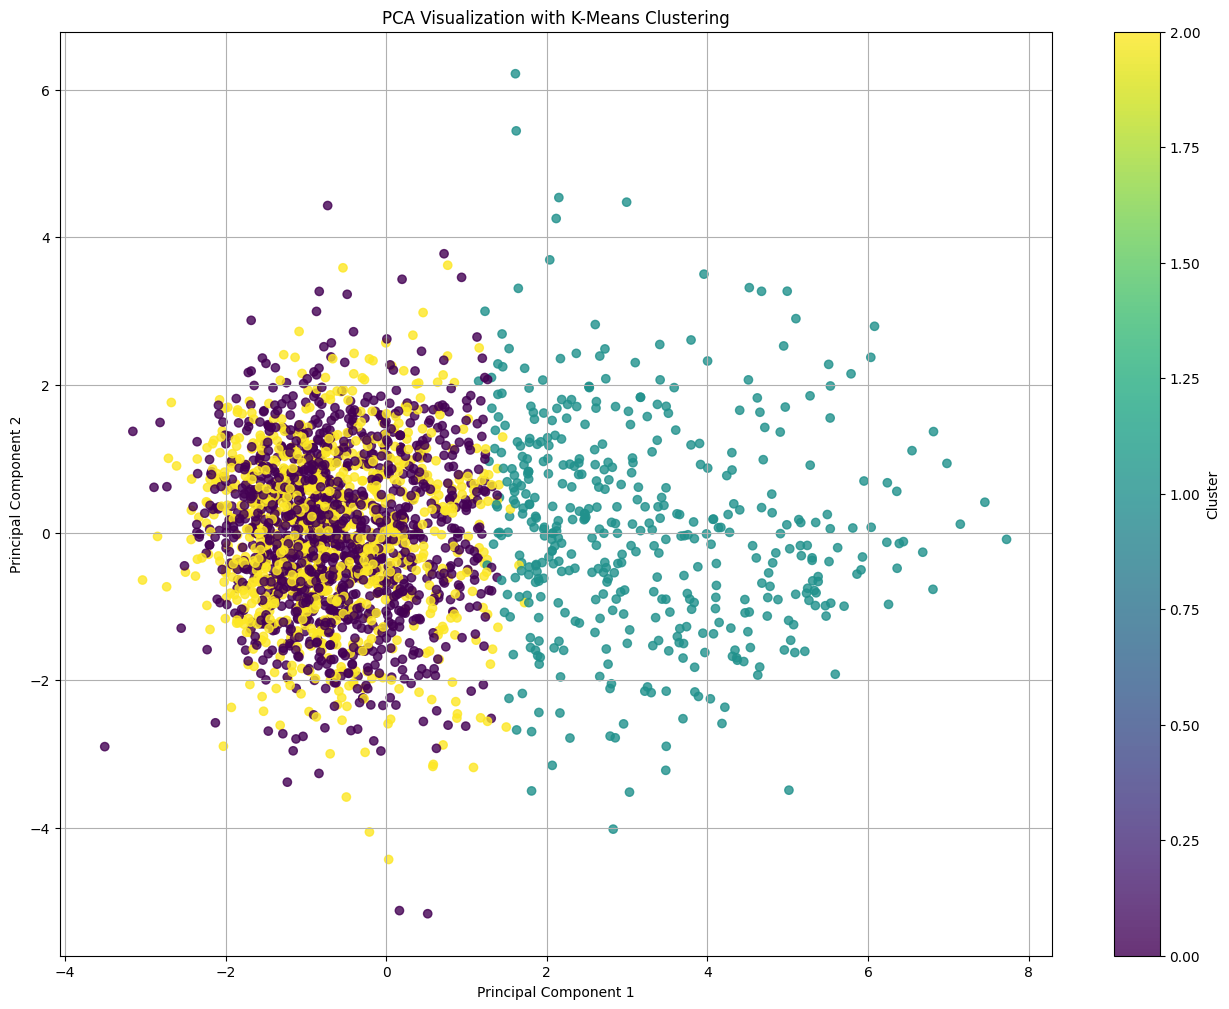

In [3]:
# remove ids for numeric data only
features = pd.read_json('./data/features.json')
# track_ids = pd.read_json('./data/track_ids.json')

non_numeric = ["analysis_url", "track_href", "type", "uri", "id"]
df_numeric = features.drop(columns=non_numeric)

# use standard scaler to centeralize and normalize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_numeric)

# apply PCA
pca = PCA(n_components=6) # only 2 dimensions for visualization
X_pca = pca.fit_transform(X_scaled)

# Apply k-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
pca_clusters = kmeans.fit_predict(X_scaled)

# Visualize PCA with cluster colors
plt.figure(figsize=(16, 12))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=pca_clusters, cmap='viridis', alpha=0.8)
plt.title('PCA Visualization with K-Means Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

colors = plt.cm.tab20(np.linspace(0, 1, len(np.unique(pca_clusters))))

# Initialize lists for coordinates, colors, and cluster names
x_list, y_list, z_list, color_list, text_list = [], [], [], [], []

# Add coordinates, colors, and cluster names for each point
for cluster_id in np.unique(pca_clusters):
    cluster_indices = np.where(pca_clusters == cluster_id)[0]
    x_list.extend(X_pca[cluster_indices, 0])
    y_list.extend(X_pca[cluster_indices, 1])
    z_list.extend(X_pca[cluster_indices, 2])
    color_list.extend([colors[cluster_id]] * len(cluster_indices))
    text_list.extend([f'Cluster {cluster_id}'] * len(cluster_indices))

# Create trace for data points
trace = go.Scatter3d(
    x=x_list,
    y=y_list,
    z=z_list,
    mode='markers',
    marker=dict(
        size=5,
        opacity=0.8,
        color=color_list
    ),
    text=text_list,  # Display cluster names on hover
    hoverinfo='text',  # Show text on hover
)

# Create layout
layout = go.Layout(
    title='PCA (K-Means)',
    scene=dict(
        xaxis=dict(title='PCA Component 1'),
        yaxis=dict(title='PCA Component 2'),
        zaxis=dict(title='PCA Component 3')
    ),
    width=900,
    height=600,
    margin=dict(l=0, r=0, b=0, t=40),
)

# Create figure
fig = go.Figure(data=[trace], layout=layout)

# Show plot
fig.show()


#### Apply t-SNE

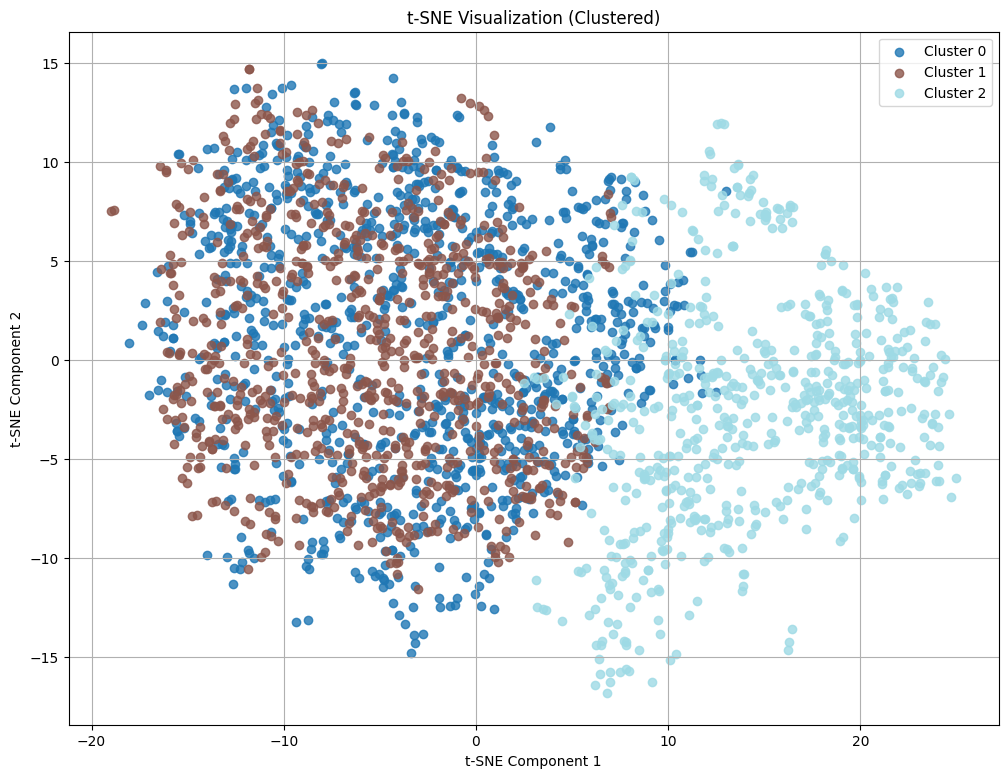

In [4]:
# using 2 components for t-SNE for visualization after reducing with PCA
tsne = TSNE(n_components=3, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# apply k-means to t-SNE results
kmeans = KMeans(n_clusters=3, random_state=42)
tsne_clusters = kmeans.fit_predict(X_tsne)

colors = plt.cm.tab20(np.linspace(0, 1, len(np.unique(tsne_clusters))))

plt.figure(figsize=(12, 9))
for cluster_id, color in zip(np.unique(tsne_clusters), colors):
    cluster_indices = np.where(tsne_clusters == cluster_id)[0]
    plt.scatter(X_tsne[cluster_indices, 0], X_tsne[cluster_indices,
                1], label=f'Cluster {cluster_id}', color=color, alpha=0.8)
plt.title('t-SNE Visualization (Clustered)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend() # legends for whether you see which cluster is which
plt.grid(True)
plt.show()

# Initialize lists for coordinates, colors, and cluster names
x_list, y_list, z_list, color_list, text_list = [], [], [], [], []

# Add coordinates, colors, and cluster names for each point
for cluster_id in np.unique(tsne_clusters):
    cluster_indices = np.where(tsne_clusters == cluster_id)[0]
    x_list.extend(X_tsne[cluster_indices, 0])
    y_list.extend(X_tsne[cluster_indices, 1])
    z_list.extend(X_tsne[cluster_indices, 2])
    color_list.extend([colors[cluster_id]] * len(cluster_indices))
    text_list.extend([f'Cluster {cluster_id}'] * len(cluster_indices))

# Create trace for data points
trace = go.Scatter3d(
    x=x_list,
    y=y_list,
    z=z_list,
    mode='markers',
    marker=dict(
        size=5,
        opacity=0.8,
        color=color_list
    ),
    text=text_list,  # Display cluster names on hover
    hoverinfo='text',  # Show text on hover
)

# Create layout
layout = go.Layout(
    title='t-SNE (K-Means)',
    scene=dict(
        xaxis=dict(title='t-SNE Component 1'),
        yaxis=dict(title='t-SNE Component 2'),
        zaxis=dict(title='t-SNE Component 3')
    ),
    width=900,
    height=600,
    margin=dict(l=0, r=0, b=0, t=40),
)

# Create figure
fig = go.Figure(data=[trace], layout=layout)

# Show plot
fig.show()

#### Apply t-SNE on PCA Data

Using *t*-SNE on data from PCA.

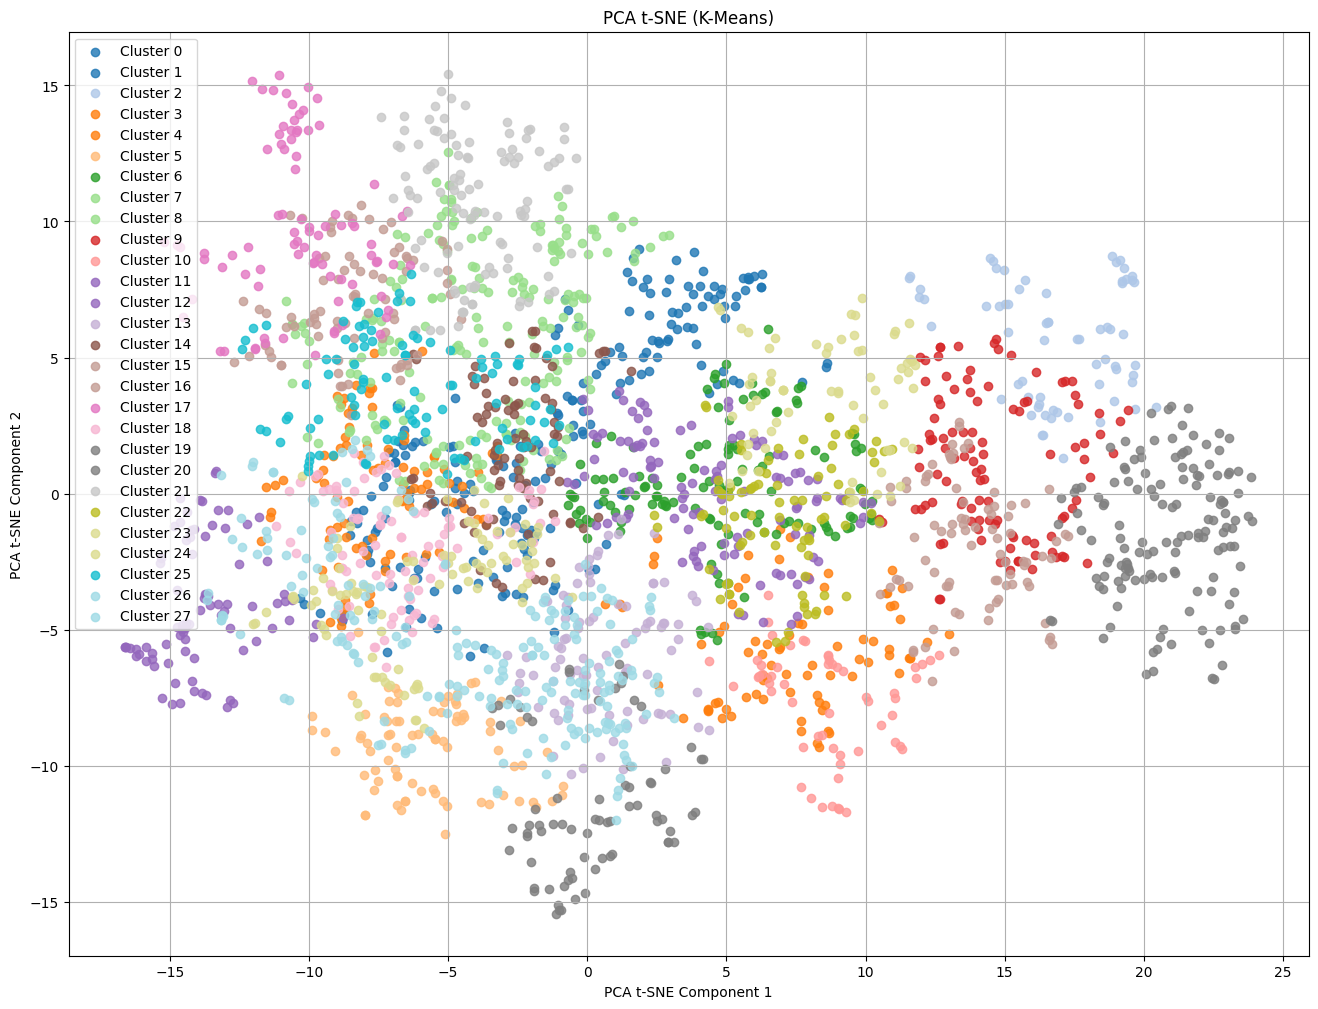

In [5]:
# using 2 components for t-SNE for visualization after reducing with PCA
pca_tsne = TSNE(n_components=3, random_state=42)
X_pca_tsne = pca_tsne.fit_transform(X_pca)

pca_tsne_num_clusters = 28

# apply k-means to t-SNE results
kmeans = KMeans(n_clusters=pca_tsne_num_clusters, random_state=42)
pca_tsne_clusters = kmeans.fit_predict(X_pca_tsne)

colors = plt.cm.tab20(np.linspace(0, 1, len(np.unique(pca_tsne_clusters))))

plt.figure(figsize=(16, 12))
for cluster_id, color in zip(np.unique(pca_tsne_clusters), colors):
    cluster_indices = np.where(pca_tsne_clusters == cluster_id)[0]
    plt.scatter(X_pca_tsne[cluster_indices, 0], X_pca_tsne[cluster_indices,
                1], label=f'Cluster {cluster_id}', color=color, alpha=0.8)
plt.title('PCA t-SNE (K-Means)')
plt.xlabel('PCA t-SNE Component 1')
plt.ylabel('PCA t-SNE Component 2')
plt.legend() # legends for whether you see which cluster is which
plt.grid(True)
plt.show()


# Initialize lists for coordinates, colors, and cluster names
x_list, y_list, z_list, color_list, text_list = [], [], [], [], []

# Add coordinates, colors, and cluster names for each point
for cluster_id in range(pca_tsne_num_clusters):
    cluster_indices = np.where(pca_tsne_clusters == cluster_id)[0]
    x_list.extend(X_pca_tsne[cluster_indices, 0])
    y_list.extend(X_pca_tsne[cluster_indices, 1])
    z_list.extend(X_pca_tsne[cluster_indices, 2])
    color_list.extend([colors[cluster_id]] * len(cluster_indices))
    text_list.extend([f'Cluster {cluster_id}'] * len(cluster_indices))

# Create trace for data points
trace = go.Scatter3d(
    x=x_list,
    y=y_list,
    z=z_list,
    mode='markers',
    marker=dict(
        size=5,
        opacity=0.8,
        color=color_list
    ),
    text=text_list,  # Display cluster names on hover
    hoverinfo='text',  # Show text on hover
)

# Create layout
layout = go.Layout(
    title='PCA t-SNE (K-Means)',
    scene=dict(
        xaxis=dict(title='PCA t-SNE Component 1'),
        yaxis=dict(title='PCA t-SNE Component 2'),
        zaxis=dict(title='PCA t-SNE Component 3')
    ),
    width=900,
    height=600,
    margin=dict(l=0, r=0, b=0, t=40),
)

# Create figure
fig = go.Figure(data=[trace], layout=layout)

# Show plot
fig.show()

In [8]:
# export ids for different clusters

clusters = [pca_clusters, tsne_clusters, pca_tsne_clusters]
names = ['pca', 'tsne', 'pca_tsne']

for i in range(len(clusters)):
    # exporting the track ids with cluster information
    ids = {}
    current_clusters = clusters[i]
    cluster_labels = current_clusters.astype(int)
    ids = [{'track_id': track_id, 'cluster_label': int(cluster_label)}
           for track_id, cluster_label in zip(track_ids, cluster_labels)]

    sorted_tracks = sorted(ids, key=lambda x: x['cluster_label'])

    with open(f'./data/ids/{names[i]}.json', 'w') as f:
        json.dump(sorted_tracks, f, indent=4)

/tmp/ipykernel_19655/2157146099.py:21: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



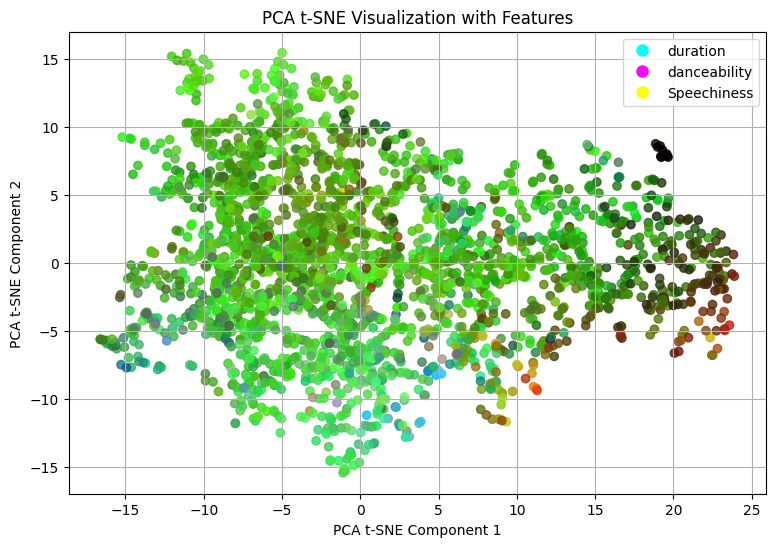

In [20]:
# Extracting the features from audio_features
danceability = features['danceability']
valence = features['valence']
speechiness = features['speechiness']

# Scale the features to range [0, 1]
danceability_scaled = danceability / danceability.max()
valence_scaled = valence / valence.max()
speechiness_scaled = speechiness / speechiness.max()

# Define CMY values based on feature values
c = danceability_scaled  # Cyan: Inverse of danceability
m = 1 - valence_scaled  # Magenta: Inverse of valence
y = 1 - speechiness_scaled  # Yellow: Inverse of speechiness

# Combine CMY values
color = np.stack((c, m, y), axis=-1)  # Stack CMY values along the last dimension

# Plot t-SNE with colored nodes
plt.figure(figsize=(9, 6))
scatter = plt.scatter(X_pca_tsne[:, 0], X_pca_tsne[:, 1], c=color, cmap='CMY', alpha=0.8)
plt.title('PCA t-SNE Visualization with Features')
plt.xlabel('PCA t-SNE Component 1')
plt.ylabel('PCA t-SNE Component 2')

# Create a legend for CMY values and RGB combinations
handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=c, markersize=10) 
    for c in ['cyan', 'magenta', 'yellow']
]
labels = ['Danceability', 'Valence', 'Speechiness']
plt.legend(handles, labels, loc='best')

plt.grid(True)
plt.show()

# Create traces for each cluster
traces = []
for cluster_id in np.unique(pca_tsne_clusters):
    cluster_indices = np.where(pca_tsne_clusters == cluster_id)[0]
    trace = go.Scatter3d(
        x=X_pca_tsne[cluster_indices, 0],
        y=X_pca_tsne[cluster_indices, 1],
        z=X_pca_tsne[cluster_indices, 2],
        mode='markers',
        marker=dict(
            size=5,
            color=color[cluster_indices],  # Assigning color based on CMY values
            opacity=0.8
        ),
        name=f'Cluster {cluster_id}'
    )
    traces.append(trace)

# Define layout
layout = go.Layout(
    title='PCA t-SNE Visualization with Features',
    scene=dict(
        xaxis=dict(title='PCA t-SNE Component 1'),
        yaxis=dict(title='PCA t-SNE Component 2'),
        zaxis=dict(title='PCA t-SNE Component 3')
    ),
    width=900,
    height=600,
    # margin=dict(l=0, r=0, b=0, t=40),
    # legend=dict(orientation='h')
)

# Create figure
fig = go.Figure(data=traces, layout=layout)

# Show plot
fig.show()

In [15]:
# getting the average feature information for each cluster:

# Initialize dictionary to store cluster information
cluster_features = {}

# Loop through each cluster
for cluster_id in np.unique(pca_tsne_clusters):
    # Extract data points belonging to the current cluster
    cluster_indices = np.where(pca_tsne_clusters == cluster_id)[0]
    cluster_danceability = danceability[cluster_indices]
    cluster_valence = valence[cluster_indices]
    cluster_speechiness = speechiness[cluster_indices]
    
    # Calculate average feature values for the current cluster
    avg_danceability = round(np.mean(cluster_danceability), 3)
    avg_valence = round(np.mean(cluster_valence), 3)
    avg_speechiness = round(np.mean(cluster_speechiness), 3)

        # Store cluster information in dictionary
    cluster_features[str(cluster_id)] = {
        "Cluster": int(cluster_id),  # Add cluster label
        "Average Danceability": avg_danceability,
        "Average Valence": avg_valence,
        "Average Speechiness": avg_speechiness
    }
    
# Write the JSON object to a file
with open('./data/cluster_features.json', 'w') as json_file:
    json.dump(cluster_features, json_file, indent=4)


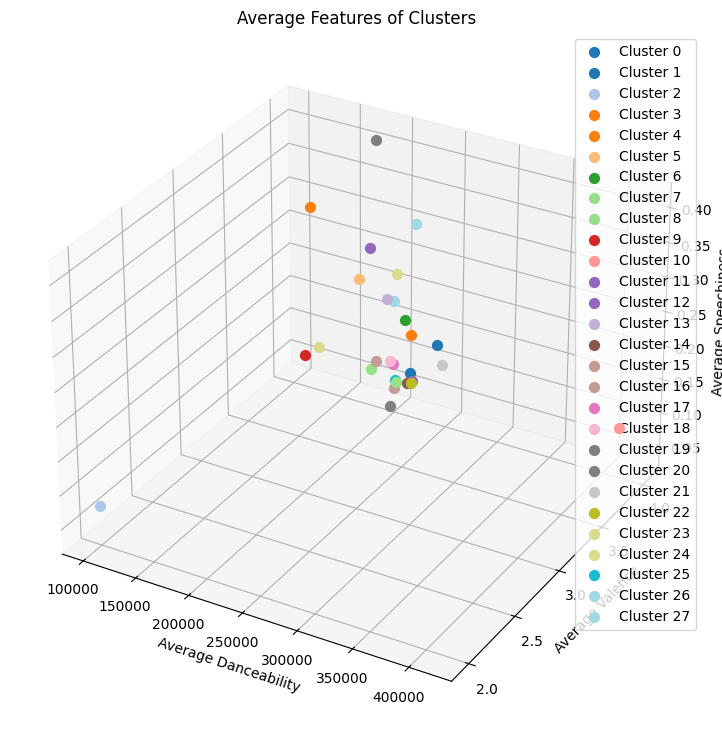

In [16]:
df = pd.read_json('./data/cluster_features.json', orient='index')

# Plot 3D scatter plot
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

# Extract feature values
danceability = df['Average Danceability']
valence = df['Average Valence']
speechiness = df['Average Speechiness']

colors = plt.cm.tab20(np.linspace(0, 1, len(np.unique(pca_tsne_clusters))))

# Assign a unique color to each cluster
for cluster_id, color in zip(range(28), colors):
    cluster_indices = df[df['Cluster'] == cluster_id].index
    ax.scatter(danceability[cluster_indices], 
               valence[cluster_indices], 
               speechiness[cluster_indices], 
               s=50, color=color, marker='o', label=f'Cluster {cluster_id}')

# Set labels and title
ax.set_xlabel('Average Danceability')
ax.set_ylabel('Average Valence')
ax.set_zlabel('Average Speechiness')
ax.set_title('Average Features of Clusters')

# Add legend
ax.legend()

# Show plot
plt.show()

# Initialize lists for coordinates, colors, and cluster names
x_list, y_list, z_list, color_list, text_list = [], [], [], [], []

# Add coordinates, colors, and cluster names for each point
for cluster_id in range(28):
    cluster_indices = df[df['Cluster'] == cluster_id].index
    x_list.extend(df.loc[cluster_indices, 'Average Danceability'])
    y_list.extend(df.loc[cluster_indices, 'Average Valence'])
    z_list.extend(df.loc[cluster_indices, 'Average Speechiness'])
    color_list.extend([colors[cluster_id]] * len(cluster_indices))
    text_list.extend([f'Cluster {cluster_id}'] * len(cluster_indices))

# Create trace for data points
trace = go.Scatter3d(
    x=x_list,
    y=y_list,
    z=z_list,
    mode='markers',
    marker=dict(
        size=5,
        opacity=0.8,
        color=color_list
    ),
    text=text_list,  # Display cluster names on hover
    hoverinfo='text',  # Show text on hover
)

# Create layout
layout = go.Layout(
    title='Average Features of Clusters',
    scene=dict(
        xaxis=dict(title='Average Danceability'),
        yaxis=dict(title='Average Valence'),
        zaxis=dict(title='Average Speechiness')
    ),
    width=900,
    height=600,
    margin=dict(l=0, r=0, b=0, t=40),
)

# Create figure
fig = go.Figure(data=[trace], layout=layout)

# Show plot
fig.show()


In [ ]:
# exporting the track ids with cluster information 
# cluster_track_ids = {}
# clusters = clusters.astype(int)
# cluster_track_ids = [{'track_id': track_id, 'cluster_label': int(cluster_label)}
#                      for track_id, cluster_label in zip(track_ids, clusters)]

# sorted_tracks = sorted(cluster_track_ids, key=lambda x: x['cluster_label'])

# with open('clustered_track_ids.json', 'w') as f:
#     json.dump(sorted_tracks, f, indent=4)